In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import joblib

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
train_df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

In [7]:
# Display dataset information
print(f"Dataset Shape: {train_df.shape}")
print(train_df.columns)
print(train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum())

Dataset Shape: (159571, 8)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


In [8]:
def clean_text(text):
    """
    Clean and preprocess text data
    """
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, URLs and numbers
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [9]:
# Apply text preprocessing
train_df['clean_comment'] = train_df['comment_text'].apply(clean_text)

In [11]:
# Create labels array (multi-label classification)
labels = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    train_df['clean_comment'], 
    labels, 
    test_size=0.2, 
    random_state=42
)

In [12]:
# Tokenization and padding
max_features = 200000  # Maximum number of words to keep
max_len = 200  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

# Model parameters
embedding_dim = 100
vocab_size = min(max_features, len(tokenizer.word_index) + 1)

In [26]:
# Create model: Bidirectional LSTM with Embedding
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))  # 6 toxicity types

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=64,
    verbose=1
)

Epoch 1/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 108s 50ms/step - accuracy: 0.7945 - loss: 0.1281 - val_accuracy: 0.9941 - val_loss: 0.0514
Epoch 2/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 99s 50ms/step - accuracy: 0.9905 - loss: 0.0496 - val_accuracy: 0.9941 - val_loss: 0.0504
Epoch 3/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 99s 50ms/step - accuracy: 0.9923 - loss: 0.0410 - val_accuracy: 0.9941 - val_loss: 0.0560
Epoch 4/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 99s 50ms/step - accuracy: 0.9897 - loss: 0.0357 - val_accuracy: 0.9941 - val_loss: 0.0666
Epoch 5/5
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 99s 50ms/step - accuracy: 0.9899 - loss: 0.0318 - val_accuracy: 0.9935 - val_loss: 0.0739


In [30]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_pad, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

998/998 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9936 - loss: 0.0737
Validation Loss: 0.0739
Validation Accuracy: 0.9935


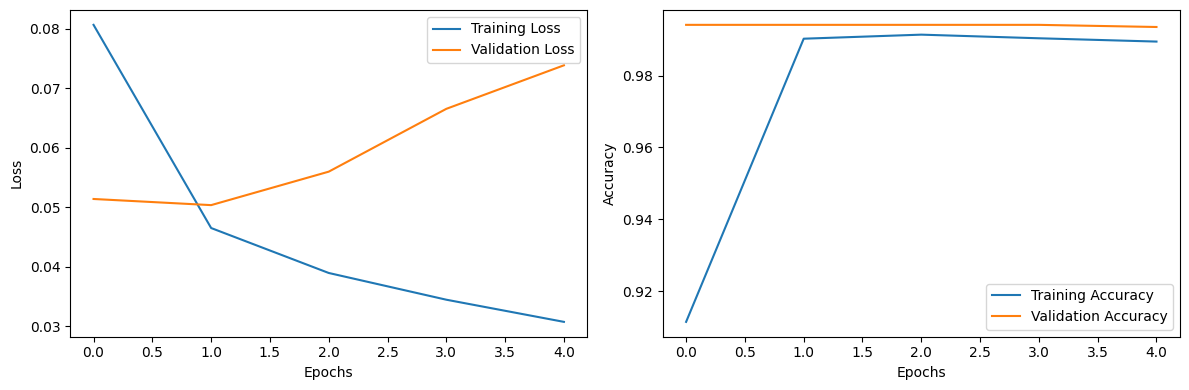

In [31]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
text = "jump off the building and die"

In [39]:
clean = clean_text(text)
# Tokenize and pad
seq = tokenizer.texts_to_sequences([clean])
padded = pad_sequences(seq, maxlen=max_len, padding='post')
# Predict
prediction = model.predict(padded)[0]

# Map results to categories
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
result = {categories[i]: float(prediction[i]) for i in range(len(categories))}

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
{'toxic': 0.8060348033905029, 'severe_toxic': 0.00024149607634171844, 'obscene': 0.041438695043325424, 'threat': 0.012360974214971066, 'insult': 0.11293487995862961, 'identity_hate': 0.02255774475634098}


In [40]:
model.save("dnn_model.h5")

In [13]:
joblib.dump(tokenizer,"Tokenizer.pkl")

['Tokenizer.pkl']